In [17]:
# importing the necessary packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV

# reading in the csv file
data = pd.read_csv('final_data.csv', index_col=0, header=0)
data.columns

Index(['year', 'state', 'pay_method_ACH', 'pay_method_credit card',
       'pay_method_paper check', 'region_central', 'region_north_east',
       'region_rocky', 'region_south', 'region_south_east', 'region_west',
       'status_Active', 'status_Decline', 'status_Returned',
       'status_Returned_90', 'income', '18_months'],
      dtype='object')

In [18]:
# Dropping rows that will not be used in the random forest
data = data.drop(['state'], axis = 1)

data.columns

#Renaming columns so they can be passed in the model
data.columns = ['year', 'pay_method_ACH', 'pay_method_credit card',
       'pay_method_paper check', 'region_central', 'region_north_east',
       'region_rocky', 'region_south', 'region_south_east', 'region_west',
       'status_Active', 'status_Decline', 'status_Returned',
       'status_Returned_90', 'income', '18_months']

In [19]:
# Splitting the data in the X and y variables
X = data.iloc[:,:-1]
Y = data['18_months']

# Splitting the data in training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=2019)

In [20]:
# Converting the data set into a matrix
data_matrix = xgb.DMatrix(data=X,label=Y)

In [21]:
# Getting the counts for the majority and minority class 
# in order to set the scale_pos_weight parameter to the
# majority class divided by the minority class
y_train.value_counts()

0    74529
1     8594
Name: 18_months, dtype: int64

In [22]:
# Starting the XGBoost
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, scale_pos_weight = 8.83893)

# Fitting the xg_reg variable
xg_reg = xg_reg.fit(X_train, y_train)

# Creating the y_pred variable
y_pred = xg_reg.predict(X_test)

In [23]:
# Creating the rmse model/variable
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE : %f" % (rmse))

RMSE : 0.445775


In [24]:
# Setting the hyper-parameters for k-fold cross validation
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'scale_pos_weight': 8.83893}

# Building the model as we did in week 10 of Data Mining
cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2019)

In [25]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.475986,0.000068,0.476077,0.000196
1,0.470794,0.003672,0.470786,0.003599
2,0.465695,0.006365,0.465784,0.006273
3,0.455703,0.007978,0.455770,0.007991
4,0.445825,0.003535,0.445873,0.003663


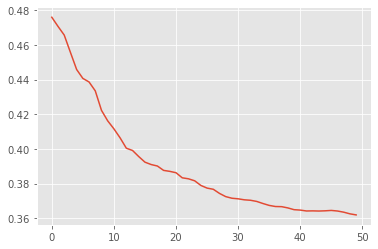

In [26]:
# Plotting the RMSE change over the training of the cross validation model above
plt.style.use('ggplot')

cv_results['test-rmse-mean'].plot()

In [27]:
# Extracting and printing the final boosting round metric.
print((cv_results["test-rmse-mean"]).tail(1))

49    0.361857
Name: test-rmse-mean, dtype: float64


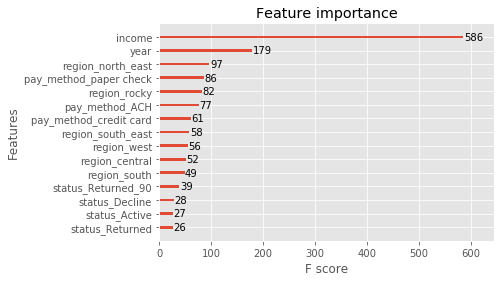

In [28]:
# Using XGBoost's feature importance to come to conclusions about the datasets
# "Building the bridge" for the company
xgb.plot_importance(xg_reg)
plt.show()

In [29]:
# Running accuracy on both sets to check for overfitting
print("Train Accuracy:",metrics.accuracy_score(y_train, xg_reg.predict(X_train)))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Train Accuracy: 0.8019320765612405
Test Accuracy: 0.8012848274866464
